In [195]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loader import PathDataModule
from tqdm import tqdm

# --- 1. Configuration and Data Loading ---
config_path = 'full.json'
config_data = json.load(open(config_path, 'r'))
print(config_data)

{'dataset': 'ogbl-collab', 'storage_dir': '../data/', 'embedding_config': './full_embedding.json', 'train_ratio': 0.3, 'hidden_dim': 128, 'max_hops': 4, 'num_neg': 50, 'num_threads': 'vast', 'max_epochs': 10, 'batch_size': 'vast', 'dim_feedforward': 128, 'nhead': 4, 'num_layers': 4, 'dropout': 0.1, 'store': 'model', 'save_text_embeddings': True, 'shallow': True, 'pre_scan': ['train'], 'adjust_no_neg_paths_samples': True, 'max_adjust': 5.0, 'positive_deviation': True, 'embedding': 'all', 'test_time': 4, 'num_ckpt': 2, 'scale_loss': True, 'chi2': False, 'lr': 0.0001, 'wandb_project': 'thesis-graph'}


In [196]:
import torch

In [197]:
import os, requests, json, pprint

try:
    cid  = os.getenv("CONTAINER_ID")          # ← set by Vast.ai inside every container
    key  = os.getenv("CONTAINER_API_KEY")     # ← scoped token for this one instance
    assert cid and key, "Not running on a Vast.ai container!"

    resp = requests.get(
        f"https://console.vast.ai/api/v0/instances/{cid}/",
        headers={"Authorization": f"Bearer {key}",
                "accept": "application/json"},
        timeout=10,
    )

    info = resp.json()
    print("Effective vCPUs:", info['instances']["cpu_cores_effective"])
    # print(info['instances'].keys())
except Exception as e:
    print("Not running on Vast.ai container, or failed to fetch instance info.")
    print("Error:", e)

Not running on Vast.ai container, or failed to fetch instance info.
Error: Not running on a Vast.ai container!


In [198]:
import json
import os

embedding_cfg_path = config_data['embedding_config'] # path to config file
print("Embedding config path:", embedding_cfg_path)
# Read config from json file at embedding cfg path
with open(embedding_cfg_path, 'r') as f:
    embedding_cfg = json.load(f)
    
embedding_cfg

Embedding config path: ./full_embedding.json


{'batch_size': 4096,
 'lr': 0.001,
 'epochs': 10,
 'model_name': 'transe',
 'hidden_channels': 128,
 'p_norm': 2}

In [199]:


# --- 2. Load exported JSON results from model.py ---

# Construct the path to your export (update these variables as needed)
save_dir = config_data['storage_dir'] + embedding_cfg['model_name'] + \
    "/" + config_data['dataset'] + "/" + config_data['wandb_project']
    
print(f"Save directory: {save_dir}")


Save directory: ../data/transe/ogbl-collab/thesis-graph


In [200]:
wandb_name = "1"      
stage = "val"  # or "test"
epoch = "0"  # e.g. "9"
test_time = False  # set True if test_time

prefix = "test" if test_time else "train"
export_path = os.path.join(save_dir, wandb_name, f"{prefix}_{stage}_{epoch}_raw.json")
print(export_path)

../data/transe/ogbl-collab/thesis-graph/1/train_val_0_raw.json


In [201]:
# Load the JSON file
with open(export_path, "r") as f:
    export_items = json.load(f)

print(f"Loaded {len(export_items)}")

Loaded 160084


In [202]:
export_items[0]

{'score': 0.10174286365509033,
 'length': 1,
 'label': 1,
 'has_neg': True,
 'pos_dist': [22.353134155273438],
 'neg_dist': [[21.08070182800293],
  [21.08070182800293],
  [21.08070182800293],
  [21.08070182800293],
  [20.94063949584961],
  [22.353134155273438],
  [22.353134155273438],
  [22.353134155273438],
  [21.128007888793945],
  [21.128007888793945],
  [21.128007888793945],
  [21.313785552978516],
  [21.313785552978516],
  [21.754823684692383],
  [21.798219680786133],
  [22.58941650390625],
  [21.19548225402832],
  [22.160743713378906],
  [21.9285831451416],
  [22.265535354614258]],
 'adjusted_score': 4.101742744445801}

In [203]:
# recompute adjusted score
max_hops = config_data['max_hops']
max_adjust = config_data['max_adjust']
print(f"Max hops: {max_hops}, Max adjust: {max_adjust}")

Max hops: 4, Max adjust: 5.0


In [204]:
# length zero adjusted to max_hops + 2
for item in tqdm(export_items):
    if item['length'] == 0:
        item['length'] = max_hops + 2

min_length = min(item['length'] for item in export_items)
print(f"Minimum length: {min_length}")

100%|██████████| 160084/160084 [00:00<00:00, 485473.88it/s]

Minimum length: 1


In [205]:
# adjusted score
for item in tqdm(export_items):
    # ratio = 1 - (item['length'] - min_length) / (max_hops + 1 - min_length)
    # item['adjusted_score'] = item['score'] + (ratio * max_adjust)
    item['adjusted_score'] = item['score']

100%|██████████| 160084/160084 [00:00<00:00, 442243.14it/s]


In [206]:
# Re-compute the percentile pos for each items in given export_items
for item in tqdm(export_items):
    if item['pos_dist'] is not None:
        pos = torch.tensor(item['pos_dist'])
        if item['neg_dist'] is None:
            item['percentile_pos'] = 1.0
            continue
        
        neg = torch.tensor(item['neg_dist'])
        
        if config_data["positive_deviation"]:
            neg = torch.cat([neg, pos.unsqueeze(0)], dim=0)
        
        mean, std = neg.mean(0), neg.std(0, correction=0)
        z = torch.where(std > 1e-4, (pos - mean) / std,
                        torch.zeros(pos.shape, dtype=pos.dtype, device=pos.device))
        mean_z = z.mean()
    
        item['loss'] = mean_z.item() if config_data['scale_loss'] else torch.asinh(mean_z).item()
        item['percentile_pos'] = 1.0 - torch.special.ndtr(mean_z).item()
    else:
        item['percentile_pos'] = 0.0

100%|██████████| 160084/160084 [00:03<00:00, 45523.87it/s] 


In [207]:
export_items[3]

{'score': 0.0,
 'length': 6,
 'label': 1,
 'has_neg': False,
 'pos_dist': None,
 'neg_dist': None,
 'adjusted_score': 0.0,
 'percentile_pos': 0.0}

In [208]:
# Get list of label 0 but non-zero length
neg_items = [item for item in export_items if item['label'] == 0 and item['has_neg']]
print(f"Filtered non-zero items: {len(neg_items)}")

Filtered non-zero items: 7083


In [209]:
neg_items[200]

{'score': 0.07763171195983887,
 'length': 4,
 'label': 0,
 'has_neg': True,
 'pos_dist': [21.756620407104492,
  20.32785987854004,
  22.24242401123047,
  21.86017417907715],
 'neg_dist': [[21.756620407104492,
   20.529212951660156,
   20.60442352294922,
   20.41798973083496],
  [21.756620407104492,
   20.529212951660156,
   20.60442352294922,
   20.450239181518555],
  [22.24396324157715, 20.29498863220215, 20.3772029876709, 20.47519302368164],
  [22.24396324157715, 20.29498863220215, 20.3772029876709, 20.47519302368164],
  [22.24396324157715, 20.29498863220215, 20.3772029876709, 20.47519302368164],
  [22.24396324157715, 20.29498863220215, 20.3772029876709, 20.376419067382812],
  [22.24396324157715, 20.29498863220215, 20.3772029876709, 20.376419067382812],
  [22.24396324157715, 20.29498863220215, 20.3772029876709, 20.376419067382812],
  [21.756620407104492,
   20.32785987854004,
   20.29673194885254,
   20.334518432617188],
  [22.20726203918457,
   20.6400089263916,
   20.39439392089843

In [210]:
pos_items = [item for item in export_items if item['label'] == 1 and item['has_neg']]
print(f"Filtered positive items: {len(pos_items)}")

Filtered positive items: 47553


In [211]:
pos_items[0]

{'score': 0.10174286365509033,
 'length': 1,
 'label': 1,
 'has_neg': True,
 'pos_dist': [22.353134155273438],
 'neg_dist': [[21.08070182800293],
  [21.08070182800293],
  [21.08070182800293],
  [21.08070182800293],
  [20.94063949584961],
  [22.353134155273438],
  [22.353134155273438],
  [22.353134155273438],
  [21.128007888793945],
  [21.128007888793945],
  [21.128007888793945],
  [21.313785552978516],
  [21.313785552978516],
  [21.754823684692383],
  [21.798219680786133],
  [22.58941650390625],
  [21.19548225402832],
  [22.160743713378906],
  [21.9285831451416],
  [22.265535354614258]],
 'adjusted_score': 0.10174286365509033,
 'loss': 1.2716835737228394,
 'percentile_pos': 0.10174286365509033}

In [237]:
K = 500
# Select top K items in negative highest adjsuted scores
top_neg = sorted(
    neg_items, key=lambda x: x['percentile_pos'], reverse=True)[:K]
print(f"Top {K} negative items: {len(top_neg)}")

Top 500 negative items: 500


In [238]:
top_neg[-1]

{'score': 0.8685190081596375,
 'length': 4,
 'label': 0,
 'has_neg': True,
 'pos_dist': [21.195392608642578,
  22.33131980895996,
  20.51560401916504,
  22.107666015625],
 'neg_dist': [[21.525774002075195,
   20.74609375,
   21.451709747314453,
   22.30440330505371],
  [21.525774002075195, 20.74609375, 21.451709747314453, 22.30440330505371],
  [22.425880432128906,
   22.030746459960938,
   22.21149253845215,
   20.321128845214844],
  [22.425880432128906,
   22.030746459960938,
   22.21149253845215,
   20.321128845214844],
  [22.425880432128906,
   22.030746459960938,
   22.21149253845215,
   20.321128845214844],
  [22.425880432128906,
   22.030746459960938,
   22.21149253845215,
   20.9583740234375],
  [22.425880432128906,
   22.030746459960938,
   22.21149253845215,
   20.9583740234375],
  [22.425880432128906,
   22.030746459960938,
   22.21149253845215,
   20.9583740234375],
  [22.425880432128906,
   22.030746459960938,
   22.21149253845215,
   22.2542667388916],
  [22.42588043212890

In [239]:
top_neg_score = top_neg[-1]['percentile_pos']
print(f"Top negative score: {top_neg_score}")

Top negative score: 0.86851766705513


In [240]:
torch.tensor(top_neg[-1]['neg_dist'])

tensor([[21.5258, 20.7461, 21.4517, 22.3044],
        [21.5258, 20.7461, 21.4517, 22.3044],
        [22.4259, 22.0307, 22.2115, 20.3211],
        [22.4259, 22.0307, 22.2115, 20.3211],
        [22.4259, 22.0307, 22.2115, 20.3211],
        [22.4259, 22.0307, 22.2115, 20.9584],
        [22.4259, 22.0307, 22.2115, 20.9584],
        [22.4259, 22.0307, 22.2115, 20.9584],
        [22.4259, 22.0307, 22.2115, 22.2543],
        [22.4259, 22.0307, 22.2115, 22.2543],
        [22.4259, 22.0307, 22.2115, 22.2543],
        [22.4259, 22.0307, 22.2115, 20.6816],
        [22.4259, 22.0307, 22.2115, 20.6816],
        [22.4259, 22.0307, 22.2115, 20.6816],
        [22.4259, 22.0307, 22.2115, 20.3517],
        [22.4259, 22.0307, 22.2115, 20.3517],
        [22.4259, 22.0307, 22.2115, 20.3517],
        [22.4259, 22.0307, 22.2115, 21.2906],
        [22.4259, 22.0307, 22.2115, 21.2906],
        [22.4259, 22.0307, 22.2115, 21.2906]])

In [241]:
# Sort the positive items by adjusted score
top_pos = sorted(pos_items, key=lambda x: x['percentile_pos'], reverse=True)
print(f"Top positive items: {len(top_pos)}")

Top positive items: 47553


In [242]:
top_pos[-1]

{'score': 3.874301910400391e-06,
 'length': 3,
 'label': 1,
 'has_neg': True,
 'pos_dist': [20.6094913482666, 22.290287017822266, 20.304506301879883],
 'neg_dist': [[20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20.388105392456055, 21.016027450561523, 20.249814987182617],
  [20

In [243]:
# How many pos items higher adjusted scores than last item in top_neg
higher_pos = [
    item for item in top_pos if item['percentile_pos'] > top_neg_score]
len(higher_pos)

11120

In [244]:
len(higher_pos) / len(pos_items)

0.23384434210249616

In [245]:
top_neg[2]

{'score': 0.9999939799308777,
 'length': 4,
 'label': 0,
 'has_neg': True,
 'pos_dist': [20.465625762939453,
  22.11510467529297,
  20.927635192871094,
  22.144454956054688],
 'neg_dist': [[22.61302375793457,
   22.304262161254883,
   22.446243286132812,
   22.44624137878418],
  [22.61302375793457,
   22.304262161254883,
   22.446243286132812,
   22.44624137878418],
  [22.61302375793457,
   22.304262161254883,
   22.446243286132812,
   22.44624137878418],
  [22.61302375793457,
   22.304262161254883,
   22.446243286132812,
   22.44624137878418],
  [22.61302375793457,
   22.304262161254883,
   22.446243286132812,
   22.44624137878418],
  [22.61302375793457,
   22.304262161254883,
   22.446243286132812,
   22.44624137878418],
  [22.61302375793457,
   22.304262161254883,
   22.446243286132812,
   22.44624137878418],
  [22.61302375793457,
   22.304262161254883,
   22.446243286132812,
   22.44624137878418],
  [22.61302375793457,
   22.304262161254883,
   22.446243286132812,
   22.44624137878

In [246]:
higher_pos[-1]

{'score': 0.8685271739959717,
 'length': 3,
 'label': 1,
 'has_neg': True,
 'pos_dist': [20.376426696777344, 22.289064407348633, 20.222091674804688],
 'neg_dist': [[21.669301986694336, 22.358154296875, 22.32600212097168],
  [21.669301986694336, 22.358154296875, 22.32600212097168],
  [21.669301986694336, 22.358154296875, 22.272611618041992],
  [20.9945068359375, 22.142053604125977, 21.41111183166504],
  [20.9945068359375, 22.53607940673828, 21.47248077392578],
  [20.9945068359375, 22.142053604125977, 22.515480041503906],
  [20.9945068359375, 22.53607940673828, 21.710390090942383],
  [20.9945068359375, 22.53607940673828, 22.405364990234375],
  [20.9945068359375, 22.142053604125977, 21.72614288330078],
  [21.669301986694336, 22.358154296875, 21.32685661315918],
  [21.343965530395508, 21.37531852722168, 21.3053035736084],
  [20.9945068359375, 22.142053604125977, 21.83551597595215],
  [20.543556213378906, 21.58470916748047, 21.905807495117188],
  [20.543556213378906, 21.58470916748047, 21.9

In [247]:
# example = top_pos[40000]
example = top_neg[-2]
example

{'score': 0.8685919046401978,
 'length': 4,
 'label': 0,
 'has_neg': True,
 'pos_dist': [20.548025131225586,
  20.432771682739258,
  22.29763412475586,
  20.774751663208008],
 'neg_dist': [[22.23824119567871,
   20.307109832763672,
   22.408586502075195,
   22.216800689697266],
  [22.23824119567871,
   20.307109832763672,
   22.408586502075195,
   22.216800689697266],
  [22.23824119567871,
   20.307109832763672,
   22.408586502075195,
   22.216800689697266],
  [22.23824119567871,
   20.307109832763672,
   22.408586502075195,
   22.216800689697266],
  [22.23824119567871,
   20.307109832763672,
   22.408586502075195,
   22.048505783081055],
  [22.23824119567871,
   20.307109832763672,
   22.408586502075195,
   22.048505783081055],
  [22.23824119567871,
   20.307109832763672,
   22.408586502075195,
   22.048505783081055],
  [22.23824119567871,
   20.307109832763672,
   22.408586502075195,
   22.048505783081055],
  [22.20667266845703,
   22.26700210571289,
   22.30660629272461,
   21.18798

In [248]:
pos = torch.tensor(example['pos_dist']) # (length, )
neg = torch.tensor(example['neg_dist']) # (num_neg, length)

In [249]:
if config_data["positive_deviation"]:
    # Add pos (length, ) to neg pool (num_neg, length)
    neg = torch.cat([neg, pos.unsqueeze(0)], dim=0)

In [250]:
pos.shape, neg.shape

(torch.Size([4]), torch.Size([21, 4]))

In [251]:
pos

tensor([20.5480, 20.4328, 22.2976, 20.7748])

In [252]:
mean, std = neg.mean(0), neg.std(0, correction=0)
print(mean, std)

tensor([21.8314, 21.4969, 22.1402, 21.6187]) tensor([0.5686, 1.0221, 0.4805, 0.5595])


In [253]:
z = torch.where(std > 1e-4, (pos - mean) / std, torch.zeros(pos.shape, dtype=pos.dtype, device=pos.device))
mean_z = z.mean()
print(z, mean_z)

tensor([-2.2572, -1.0411,  0.3277, -1.5084]) tensor(-1.1198)


In [254]:
# arcsinh(mean z)
arcsinh_mean_z = torch.asinh(mean_z)
print(f"Arcsinh mean z: {arcsinh_mean_z}")

Arcsinh mean z: -0.9635718464851379


In [255]:
percentile_pos = 1.0 - torch.special.ndtr(mean_z).item()

In [256]:
print(f"Percentile of positive item: {percentile_pos:.4f}")

Percentile of positive item: 0.8686


In [257]:
pos_losses = torch.tensor([item['loss'] for item in pos_items])
neg_losses = torch.tensor([item['loss'] for item in neg_items])
print(pos_losses.shape, neg_losses.shape)

torch.Size([47553]) torch.Size([7083])


In [258]:
print(pos_losses.mean(), pos_losses.std())
print(neg_losses.mean(), neg_losses.std())

tensor(-0.3501) tensor(1.1651)
tensor(0.9054) tensor(1.2924)


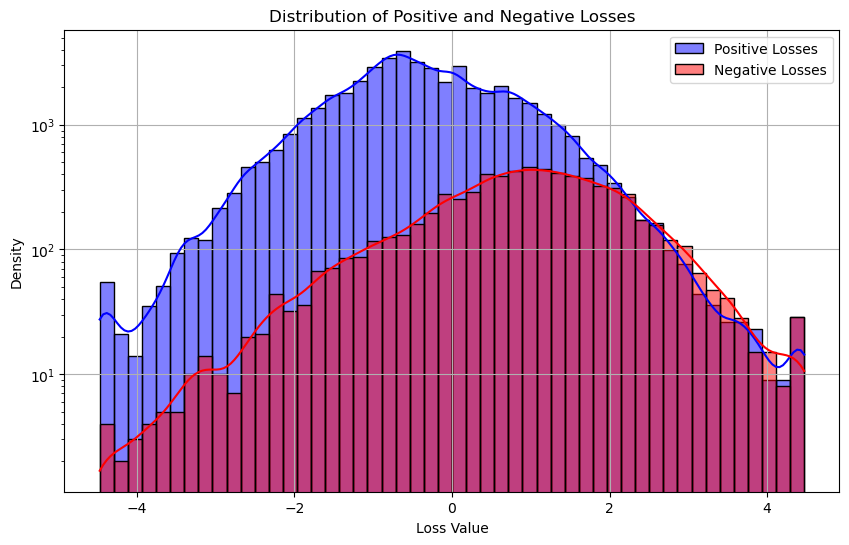

In [259]:
# Plot distribution of these two pos neg losses
plt.figure(figsize=(10, 6))
sns.histplot(pos_losses, bins=50, color='blue', label='Positive Losses', kde=True, stat='count')
sns.histplot(neg_losses, bins=50, color='red', label='Negative Losses', kde=True, stat='count')
plt.title('Distribution of Positive and Negative Losses')
plt.xlabel('Loss Value')
plt.ylabel('Density')
# log scale yaxis
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()